In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
import matplotlib.pyplot as plt
import os

In [4]:
epoch_num = 5
sequence_length = 8  # Number of time steps to consider

# Define file and directory names
file_name = '0_61938.csv'
data_dir = 'ohlc_data'
# parent_dir = 'forexPredictor'
# repo = 'Repos_git'
# repo_dir = 'Make_Money_with_Tensorflow_2.0'
# Get the absolute base directory dynamically
base_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Move up one level

# Construct the full file path in an OS-independent way
# data_path = os.path.join(base_dir, repo, repo_dir, parent_dir, data_dir, file_name)
data_path = os.path.join(base_dir, data_dir, file_name)

# Check if the file exists before using it
if os.path.exists(data_path):
    print(f"✅ File found: {data_path}")
else:
    print(f"❌ Error: File not found at {data_path}")


ucols=['Open', 'High', 'Low', 'Close']
data_main = pd.read_csv(data_path, usecols=ucols)
data_main.reset_index(drop=True, inplace=True)
data_main.head()


✅ File found: D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\0_61938.csv


,Open,High,Low,Close
0,1.20997,1.21089,1.20966,1.20999
1,1.20481,1.20569,1.20479,1.20538
2,1.20537,1.20574,1.20341,1.20553
3,1.20556,1.20689,1.20442,1.20469
4,1.20468,1.20599,1.20380,1.20573


1936/1936 [==============================] - 3s 1ms/step


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch 1/20
1936/1936 [==============================] - 7s 3ms/step - loss: 0.0529 - accuracy: 0.9788
Epoch 2/20
1936/1936 [==============================] - 5s 3ms/step - loss: 0.0236 - accuracy: 0.9903
Epoch 3/20
1936/1936 [==============================] - 5s 3ms/step - loss: 0.0171 - accuracy: 0.9930
Epoch 4/20
1936/1936 [==============================] - 5s 3ms/step - loss: 0.0147 - accuracy: 0.9941
Epoch 5/20
1936/1936 [==============================] - 6s 3ms/step - loss: 0.0121 - accuracy: 0.9949
Epoch 6/20
1936/1936 [==============================] - 5s 3ms/step - loss: 0.0103 - accuracy: 0.9958
Epoch 7/20
1936/1936 [==============================] - 5s 3ms/step - loss: 0.0106 - accuracy: 0.9958
Epoch 8/20
1936/1936 [==============================] - 6s 3ms/step - loss: 0.0093 - accuracy: 0.9960
Epoch 9/20
1936/1936 [==============================] - 6s 3ms/step - loss: 0.0094 - accuracy: 0.9961
Epoch 10/20
1936/1936 [==============================] - 6s 3ms/step - loss: 0.008

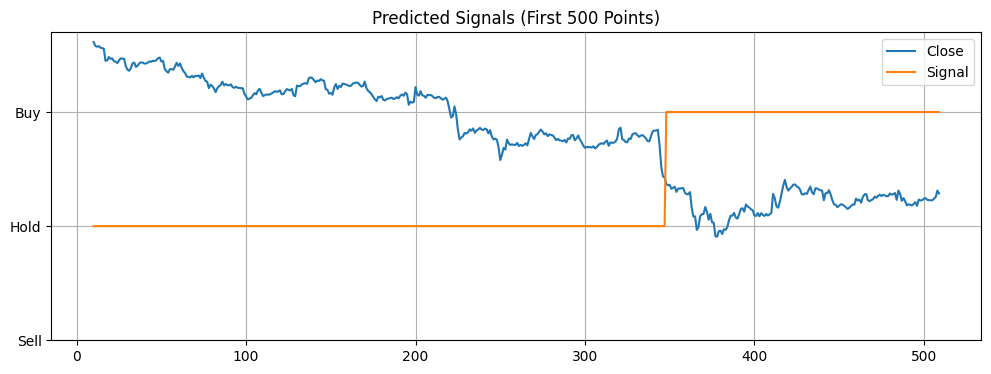

In [5]:


# --- 1. Load and Normalize OHLC Data ---
# Assume df is your DataFrame with 'Open', 'High', 'Low', 'Close'
df = data_main.copy()
scaler = StandardScaler()
df[["Open", "High", "Low", "Close"]] = scaler.fit_transform(df[["Open", "High", "Low", "Close"]])

# --- 2. Create Sliding Windows ---
def create_ohlc_windows(df, window_size=10):
    X = []
    for i in range(len(df) - window_size):
        window = df[["Open", "High", "Low", "Close"]].iloc[i:i + window_size].values
        X.append(window)
    return np.array(X)

X = create_ohlc_windows(df)

# --- 3. Define the Encoder Model ---
def create_encoder(input_shape):
    inp = Input(shape=input_shape)
    x = LSTM(64, return_sequences=False)(inp)
    x = Dense(32, activation='relu')(x)
    return Model(inputs=inp, outputs=x)

encoder = create_encoder((X.shape[1], X.shape[2]))
features = encoder.predict(X)

# --- 4. KMeans Clustering ---
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(features)

# --- 5. Map Clusters to Buy/Sell/Hold ---
returns = (df["Close"].shift(-1) - df["Close"]) / df["Close"]
returns = returns.iloc[10:].values[:len(cluster_labels)]

cluster_return_map = {}
for i in range(num_clusters):
    avg_return = np.mean(returns[cluster_labels == i])
    cluster_return_map[i] = avg_return

sorted_clusters = sorted(cluster_return_map, key=cluster_return_map.get)
cluster_to_label = {sorted_clusters[0]: "Sell", sorted_clusters[1]: "Hold", sorted_clusters[2]: "Buy"}
labels = np.vectorize(cluster_to_label.get)(cluster_labels)

# --- 6. Train Classifier on Cluster Labels ---
le = LabelEncoder()
y = le.fit_transform(labels)

x = Dense(num_clusters, activation='softmax')(encoder.output)
final_model = Model(inputs=encoder.input, outputs=x)
final_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
final_model.fit(X, y, epochs=20, batch_size=32)

# --- 7. Predict and Visualize ---
predictions = final_model.predict(X)
predicted_labels = np.argmax(predictions, axis=1)
predicted_signals = le.inverse_transform(predicted_labels)

# Add to DataFrame
df_signals = df.iloc[10:].copy()
df_signals["Signal"] = predicted_signals

# Optional: Plot
signal_map = {"Sell": -1, "Hold": 0, "Buy": 1}
numeric_signals = df_signals["Signal"].map(signal_map)

plt.figure(figsize=(12, 4))
df_signals["Close"].iloc[:500].plot(label="Close")
numeric_signals.iloc[:500].plot(label="Signal")
plt.yticks([-1, 0, 1], ["Sell", "Hold", "Buy"])
plt.title("Predicted Signals (First 500 Points)")
plt.legend()
plt.grid(True)
plt.show()


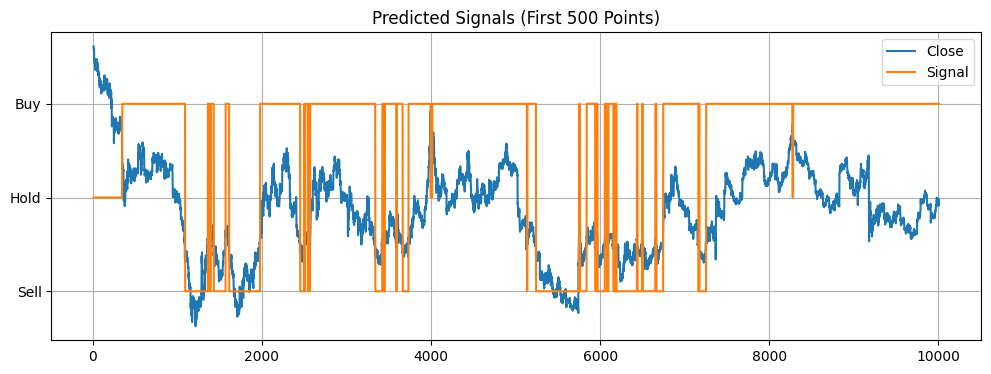

In [8]:
plt.figure(figsize=(12, 4))
df_signals["Close"].iloc[:10000].plot(label="Close")
numeric_signals.iloc[:10000].plot(label="Signal")
plt.yticks([-1, 0, 1], ["Sell", "Hold", "Buy"])
plt.title("Predicted Signals (First 500 Points)")
plt.legend()
plt.grid(True)
plt.show()
